### Multilayer Perceptron (MLP) for binary classification

1. A multilayer perceptron is a stack of fully connected (FC) layers
2. Binary classification indicates the output can be treated as a coin toss(Yes/No or ClassA/ClassB)

This notebook provides handlers to generate MLP models with varying number of hidden layers and nodes per layer using tensorflow.keras

* Tensorflow is the software module, available here as a Python module) that provides the algorithms, data structures, etc necessary to do ML.
* It is not the only one, but it is one of the few with great support, development and compatibility with GPU/TPU. This means the same code can be executed on an ordinary CPU, but also much faster chips like a GPU.
* Another very good software module is Torch (and its Python module, pytorch). Tensorflow is made by Google and Torch by Facebook.
* Keras runs on top of tensorflow to abstract away the fiddly details of the ML and provide default and reasonable settings for most things. It just simplifies the Tensorflow API (the Tensorflow commands)
* Keras is to Tensorflow what simple English is to Shakespeare English (with the nuance that one can still implement advanced/complex models without the need to write actual Tensorflow code)

The notebook is compatible with Snakemake. See Snakemake cell below if you wanna know more or disable Snakemake.
You probably want to disable Snakemake if you want to provide the loomfile, etc manually just by hardcoding them in the notebook.

Workflow and details
===========================

1. Load software dependencies (Python modules)


2. Load data to Python as an AnnData object (from a loomfile)

 2.1 The data can be selected via Snakemake or via hardcoded paths/variables

3. **Define a model** -> Specify architecture i.e. how many layers, how many nodes, activation functions, etc
4. **Compile a model** -> Provide a loss function, an optimizer and optionally performance metrics
  * The loss function is the mathematical expression that evaluates the error i.e. the difference between truth and prediction.
  The loss function depends on the prediction task. It's not the same if the model is performing regression, classification, etc. And even within classification (like this case) several losses could be used
  
  * The optimizer is the algorithm that given a loss (i.e. the output of the loss _function_) updates the weights (parameters) of the model in order to decrease said loss in the next training iteration. This can be done in different ways,
  but most algorithms consist of a variation of Stochastic Gradient Descent (SGD) and the standard backpropagation algorithm.
  
  * A performance metric quantifies in some way how well the model is doing. The loss is a performance metric itself, but it's hard to interpret in absolute terms.
  For a classification task, the accuracy is one possible metric to look at (just % predictions are correct).
    

5. **Train a model** -> Specify more details about how the training should happen (batch size, number of epochs, ...) and actually expose the model to the data and make it "learn"

  * Batch size is the number of datapoints (fly brain cells in this case) that are passed through the network before the loss is updated. Each new value of the loss is computed on `batch_size` number of cells.
  A default and common batch size is 32.
  One could take the whole dataset as a batch, but that would take painfully long (it would have to give a prediction for ALL cells and then compute the loss) and the obtained loss is probably gonna be very similar to the loss obtained on a small sample (batch). One could also use a batch of 1, which is as fast as it can get, but then it can be very noisy. 32 is a nice value because it's a nice compromise between robust and efficient loss computations.
  
  * One epoch is fulfilled when the model has seen each datapoint (brain cell) once. This can happen in any number of iterations. If the batch size is equal to the size of the dataset, one iteration is one epoch. If the batch size is 1, then a number of iterations equal to the size of the dataset is needed for an epoch to be completed. If the batch size is 32, then we need `(dataset_size / 32 + 1)` iterations.
  
  
  
  

### Load software

In [1]:
import sys
import os.path
import time
import logging
from tqdm import tqdm_notebook as tqdm
from typing import List, Tuple, Union, Dict
import random
import pickle

In [2]:
import tensorflow as tf
import h5py
import anndata
import scanpy
import loompy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
import sklearn.model_selection # for train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [4]:
import sleepapp

In [5]:
tf.random.set_seed(
    2021
)

Display the software versions, for reproducibility

* `Python`
* `tensorflow`
* `scanpy`
* `loompy`
* `anndata`

are highly susceptible to change their behavior significantly, thus this notebook is actually unlikely to work unless your versions match exactly to those listed below

If it works, even with different versions, it either is a miracle or you don't get an error but the results are wrong!!

The right version of this packages is available on cv1 in the `TF` conda environment / kernel
You can select this environment by going to the top right corner and selecting the kernel called `TF`

Please note. Tensorflow has system dependencies to work with the GPU. More concretely it needs the right CUDA, cuDNN and friends. So checking the tensorflow version is not enough if you want to run the GPU.
Make sure the right CUDA, cuDNN, etc (right meaning compatible with tensorflow 2.1.0) is available in your system. It is on cv1.

In [7]:
%load_ext watermark
%watermark --iversions

tensorflow: 2.1.0
anndata   : 0.7.5
scanpy    : 1.6.0
matplotlib: 3.1.3
loompy    : 3.0.6
numpy     : 1.19.5
pandas    : 1.2.0
h5py      : 2.10.0
sys       : 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
logging   : 0.5.1.2
sklearn   : 0.22.1



## Load data

#### Hardcoded

If you are a human, run this to specify the paths/variables below
AND DONT RUN THE CELL STARTING WITH TRY: SNAKEMAKE. Alternatively, run the Snakamek cell if you want to load the default values

If you are a machine, this cell is irrelevant 

In [8]:
loomfile = "/1TB/Cloud/Lab/Projects/SleepSignature/workflow/results/20201224/scran/y_KCs/y_KCs_grouping-Condition.loom" # path to the loomfile with the data
# NOTE: even if it has scran on the name, it is not scran normalized. You can check because the counts are all integers
# The correction factor is there through as a cell metadata column called sizeFactor. But it is not applied to the data when saving to the loomfile
# One can optionally apply it after loading the loomfile. But we dont for now

# column in the cell metadata that we want to predict
# one could try to predict Run (batch), Genotype (DGRP line) or Condition (detailed experimental condition) too
target = "Treatment"  

# where to save the weights of the model
# the model gets saved as two files inside the directory specified in the path below
# a json file with the structure
# an h5fd file with the weights
model_name = "/1TB/Cloud/Lab/Projects/SleepSignature/sleep_classifier/results/y_KCs_Treatment"

# where to save the results of the model
summary_csv = '/1TB/Cloud/Lab/Projects/SleepSignature/sleep_classifier/results/y_KCs_Treatment.csv'
test_str_txt = '/1TB/Cloud/Lab/Projects/SleepSignature/sleep_classifier/results/y_KCs_Treatment.txt'

random_labels = False # whether we should make up the labels (random_labels=True) or stick to the real ones (False)
# it would make sense to set to True if one wants to check what would be the performance on a completely random i.e. unpredictable target

#### Snakemake

If you are a human run this to load the default Snakemake values.

If you are a machine, the result of this cell will be different becuase you will run this notebook as many times as cell types available, and on each run you pass a different loomfile.

In [9]:
try:
    snakemake
    up = "../.."


except NameError:
    import json
    class AttrDict(dict):
        __getattr__ = dict.__getitem__
        __setattr__ = dict.__setitem__

    with open("01-MLP.json", 'r') as fh:
        snakemake = AttrDict(json.load(fh))
        up = "../"
        
loomfile = snakemake.input["loomfile"]
model_name = snakemake.params["model"]
summary_csv = snakemake.output["summary_csv"]
test_str_txt = snakemake.output["test_str_txt"]
target = snakemake.params["target"]
random_labels = False#snakemake.params["random_labels"]



Check the loomfile and target are correct

In [10]:
print(loomfile)
print(target)
print(model_name)
print(random_labels)

/1TB/Cloud/Lab/Projects/SleepSignature/workflow/results/20201224/scran/y_KCs/y_KCs_grouping-Condition.loom
Treatment
/1TB/Cloud/Lab/Projects/SleepSignature/sleep_classifier/results/y_KCs_Treatment
False


### Actually load the selected loomfile into Python as an anndata object

In [11]:
adata = sleepapp.loom2anndata(loomfile) # provides an anndata.AnnData object

Opening /1TB/Cloud/Lab/Projects/SleepSignature/workflow/results/20201224/scran/y_KCs/y_KCs_grouping-Condition.loom
Transposing loom dataset so rows become cells and columns become genes
Done


/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
adata.obs.head()

,Age,CellID,ClusterID,Clusterings.0,Clusterings.1,Clusterings.2,Clusterings.3,Clusterings.4,Clusterings.5,Clusterings.6,...,Sleep_Stage,Treatment,detected,discard,nGene,nUMI,propZero,sizeFactor,sum,total
0,6-9 days,AAACCCAGTTAGGGAC-fc9729__DGRP_Mix_Sleep_Depriv...,4,3,4,3,4,4,2,0,...,ZT 8,Wake,1298.0,0,1298,2802.0,0.870135,0.483911,2802.0,2802.0
1,6-9 days,AAACCCATCCTACTGC-fc9729__DGRP_Mix_Sleep_Depriv...,4,3,4,3,4,4,2,0,...,ZT 8,Wake,1664.0,0,1664,4794.0,0.833517,0.765969,4794.0,4794.0
2,6-9 days,AAAGGATTCCTACGGG-fc9729__DGRP_Mix_Sleep_Depriv...,4,3,4,3,4,4,2,0,...,ZT 8,Wake,2362.0,0,2362,8026.0,0.763682,1.449857,8026.0,8026.0
3,6-9 days,AAAGGGCGTTTGAAAG-fc9729__DGRP_Mix_Sleep_Depriv...,4,3,4,3,4,4,2,0,...,ZT 8,Wake,1600.0,0,1600,4022.0,0.839920,0.683532,4022.0,4022.0
4,6-7 days,AAAGGGCTCCTACCGT-fc9729__DGRP_Mix_Sleep_Depriv...,4,3,4,3,4,4,2,0,...,ZT 20,Wake,1625.0,0,1625,4303.0,0.837419,0.700299,4303.0,4303.0


Define two classes:

    * One for the dataset
    * One for the model

This is not needed, but it can be useful if one ends up repeating the same things over and over again, to keep DRY (Dont Repeat Yourself).

The MLModel class has the following advantages:

* it knows how many classes there are on the dataset.
* it selects the right loss based on the number of classes.
* it encodes the labels to digits automatically for you (this is needed by the model, since it's much easier to predict 1/0 over Wake/Sleep).
* it adds extra defaults on top of those from Keras, minimising the code you need to write to define an MLP (MultiLayer Perceptron). This is done with the sequential_model method.
* it automates saving / loading the model to just running the .save and .load methods

In [13]:
class MLModel:
    """
    Provide keras modelling
    Assume the inheriting class provides:
    
    * self.get_labels -> method returning list of labels
    * self.n_features -> attribute yielding number of features (genes)
    
    """
    
    def __init__(self):
        self._model = None
        self._le = LabelEncoder()
        
    
    def label_encoder(self, labels):
        """
        Encode str labels to integers
        """
        self._le = self._le.fit(labels)
        y = self._le.transform(labels)
        return y
    
    def get_encoding(self, codes):
        labels = self._le.inverse_transform(codes)
        mapping = {}
    
        for i in range(len(codes)):
                print(f"Label {labels[i]} = Code {codes[i]}")
                mapping[codes[i]] = labels[i]                
        return mapping
    
    def get_last_layer_activation_function(self):
        
        if self.n_classes == 1:
            return "sigmoid"
        else:
            return "softmax"
        
        
    def get_loss(self):
        
        if self.n_classes == 1:
            return "binary_crossentropy"
        else:
            return "sparse_categorical_crossentropy"
  

    def sequential_model(self, units: Union[Tuple, List] = (1000, 100)):
        """
        Define a MLP model using the Keras Sequential API
        
        Arguments:
            * units: Tuple or List where each ith element represents the number of units in the ith layer.
            First number goes to the first hidden layer i.e. the input layer does not count.
            Number of hidden units should decrease as we approach the last layer.
        
        Details:
        
        * Activation functions (AF):  An activation function is in charge of introducing non-linearity.
        Intuitively, the data space can because of non linearities, be reshaped like plasticine, and not just like a towel.
        We always ReLU (Rectified Linear Unit) activation functions for all hidden layers because it is the most well-behaved AF.
        
        The AF in the output layer is different though and depends on the number of classes.        
        
        * Kernel initializer: The weights need to get an initial value (a priori it could be all zero but that would actually make the learning not work).
        The kernel initializer gives a random set of weights that will provide a good starting point (at least not a lethal one).
        
        * Fully Connected Layers: A fully connected layer gives each of its nodes a separate weight for each of the nodes on the previous layer
        Such a layer is available in Keras as Dense.
        
        * The math behind this: Each node is doing the following computation
        
        f1 * w1 + f2 * w2 + ... + fN * wN
        
        where
        * N is the number of nodes in the previous layer
        * f1, f2, ..., f3 **is the same** for all nodes and it is the output of the previous layer
        * w1, w2, ..., wN **is different** for each node (i.e each node has its own set of weights so its processes the data in a different way)        
        """

        # define model
        model = Sequential()
        
        
        # add the first hidden layer
        # it is special because its input shape is given by the number of features in the data
        # and not the number of nodes in the previous hidden layer, obviously because there is no previous hidden layer
        model.add(Dense(units[0], activation='relu', kernel_initializer='he_normal', input_shape=(self.n_features,), name="hidden_1"))

        # add a new hidden layer for every value in units
        # the size of the hidden layer is the corresponding value
        for i in range(1, len(units)):
            model.add(Dense(units[i], activation='relu', kernel_initializer='he_normal', name=f"hidden_{i+1}"))

        # add the output layer
        model.add(Dense(self.n_classes, activation=self.get_last_layer_activation_function(), name="output"))
        self._model = model
        

    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, x):
        print("Setting model")
        self._model = x

    def set_target(self, column_name):
        self._target = column_name
    
    def compile(self, *args, **kwargs):
        # compile the model
        optimizer = kwargs.pop("optimizer", "adam")
        loss = kwargs.pop("loss", "sparse_categorical_crossentropy")
        metrics = kwargs.pop("metrics", ['accuracy'])
        self.model.compile(*args, optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)
        
    def fit(self, X, y, *args, **kwargs):
        # fit the model
        self.model.fit(X, y, *args, batch_size=32, verbose=3, **kwargs)
        
    def predict(self, data):
        yhat = self.model.predict(data)
        
        if self.n_classes == 1:
            yhat = np.array([1-yhat, yhat])          
        
        pred_class = np.argmax(yhat)
        class_score = np.max(yhat)
        return {pred_class: class_score}
        
        
        
    def save(self, model="model"):
        
        if self.model is None:
            return
        else:
            # serialize model to JSON
            model_json = self.model.to_json()
            with open(f"{model}.json", "w") as json_file:
                json_file.write(model_json)
            # serialize weights to HDF5
            self.model.save_weights(f"{model}.h5")
            print("Saved model to disk")
            
    def load(self, model="model"):
        # later...
        # load json and create model
        output_model_json = ""
        json_file = open(f"{model}.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        print(loaded_model_json)
        loaded_model = tf.keras.models.model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(f"{model}.h5")
        print("Loaded model from disk")
        self.model = loaded_model
        self.compile()
        return None

In [14]:
class Dataset(MLModel):
    
    def __init__(self, adata, *args, **kwargs):
        self._adata = adata
        super().__init__(*args, **kwargs)
        
    
    @staticmethod
    def xtype(x):
        return type(x).__module__
    

    @property
    def X(self):
        X = self._adata.X
        #print(self.xtype(X))
        if self.xtype(X) == "numpy":
            print("Returning numpy")
            return X
        else:
            return X.toarray()

    def get_features(self) -> np.array:
        """
        Return model imput features (genes) as a table of shape
        cells x genes
        """
        return self.X
        
    def get_labels(self, encode: bool = True, random: bool = False) -> List:
        """
        Return learnable feature (label)
        This should be a column in the obs table
        that the model is hypothesized to be able to infer from the transcriptome
        
        Arguments:
            * encode: the labels are returned encoded, i.e. each label becomes an integer starting from 0
            * random: if True, a set of random labels is generated with number of classes equal to those in self._target
        """

        if self._target is None:
            print("Please set _target to a column name in the cell metadata (self._adata.obs)")
            return None

        labels = self._adata.obs[self._target].values.tolist()

        if encode:
                labels = self.label_encoder(labels)
        if random:
            labels = np.random.randint(0, len(np.unique(labels)), self._adata.obs.shape[0])
        
        return labels
            
    
    @property
    def n_features(self):
        return self._adata.shape[1]
    
    @property
    def n_classes(self):
        return len(self._adata.obs[self._target].unique())
            

    def train_test_split(self, test_size=0.33, *args, **kwargs):
        X = self.get_features()
        y = self.get_labels(*args, **kwargs)
        indices = self.obs["CellID"]
        X_train, X_test, y_train, y_test, index_train, index_test = sklearn.model_selection.train_test_split(X, y, indices, test_size=test_size)
        return {
                "train": (X_train, y_train, index_train),
                "test": (X_test, y_test, index_test)
               }

    @property
    def obs(self):
        return self._adata.obs
    
    @property
    def var(self):
        return self._adata.var

1. Put the AnnData object into a Dataset (defined above) object
2. Tell the dataset what do we want to predict (the target)
3. Check everything is correct

In [15]:
data=Dataset(adata)
data.set_target(target)
print(data.n_classes)
assert data.get_features().shape[0] == len(data.get_labels())

2


Visualize the encoding. Which class gets which number?

In [16]:
data.get_encoding([i for i in range(len(data._adata.obs[data._target].unique()))])

Label Sleep = Code 0
Label Wake = Code 1


{0: 'Sleep', 1: 'Wake'}

Perform the train / test split

The train set is used to modify the weights (parameters) of the model in such a way that the model's prediction is as good as possible

But the same data that was used to train the model cannot be used to check how well it does... very bad models will artificially perform very well when given their training data!

This is why we need a test set.

**Please note**

If we are doing hyperparameter selection based on the data, we also need a validation set to select the right hyperparameters

A hyperparameter of the model is everything regarding the model that is not the weights themselves. We could have chosen a different architecture, or a different regularization scheme, learning rate, etc... If we want to find the best one using our dataset, we need to create a separate set

For now in this notebook we only need a train and test

## Split the data randomly

In [24]:
dataset_split = data.train_test_split(random=random_labels, test_size=0.33) # random split between train and test

## Split the data following some metavariable

In [25]:
def train_test_split(data, metavar: str, test_vals: List) -> Dict:
    """
    Custom split of data based on metavariables
    
    Arguments:
        metavar: column in obs DataFrame to be used to separate cells into groups
        test_vals: list of values available in the `metavar` column that identify the test set
            All values available in the column and not passed in `test_vals` are used to group the training set
            
    Return:
        dictionary with keys train and test. Each value is a tuple with an array of features, labels and cell ids.
        features is a numpy array of shape (n,m) where n is the number of datapoints in the set and m the number of features (genes, ...).
        labels is a numpy array of shape (n,) where the ith element is the label of the ith datapoint.
        indices is a numpy array of shape (n,) where the ith element is the cell id of the ith datapoint.
    """
    index_test = np.array([True if r in test_vals else False for r in data._adata.obs[metavar]])
    assert np.all(data._adata.obs.loc[index_test][metavar].unique()[0] in test_vals)
    index_train = ~index_test
    
    # labels (prediction target)
    labels  = data.get_labels(random=False)
    labels_train = labels[index_train]
    labels_test  = labels[index_test]

    # features (prediction input)
    features  = data.get_features()
    features_train = features[index_train, :]
    features_test = features[index_test, :]
    
    # cell ids (useful to keep track of where the data came from)
    cells_train = data._adata.obs["CellID"][index_train]
    cells_test = data._adata.obs["CellID"][index_test]
    
    assert features_train.shape[0] == len(labels_train)
    assert features_test.shape[0] == len(labels_test)

    print(f"{features_train.shape[0]} cells in training set")
    print(f"{features_test.shape[0]} cells in test set")

    dataset_split = {
        "train": (features_train, labels_train, cells_train),
        "test": (features_test, labels_test, cells_test),

    }
    return dataset_split

#dataset_split = train_test_split(data, "Run", "20200916")


### Define architecture (how many layers, with how many neurons, connectivity between neurons, etc)

`units=1000` means create a single hidden layer with 1000 nodes on it. So the MLP model has:

* 1 (input) layer with as many nodes as genes N
* 1 (hidden) layer where each node has N weights and there are 1000 nodes
* 1 (output) layer with 2 nodes (one for each class) where each node has ... 1000 weights because the previous layer has 1000 nodes

In [30]:
data.sequential_model(units=[1000])

#### Compile model

This sets a loss function and an optimizer


In [31]:
data.compile(optimizer='adam', loss=data.get_loss(), metrics=['accuracy'])

In [32]:
data.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 1000)              9996000   
_________________________________________________________________
output (Dense)               (None, 2)                 2002      
Total params: 9,998,002
Trainable params: 9,998,002
Non-trainable params: 0
_________________________________________________________________


#### Train model

Populate the nodes with weights that make sense i.e. correctly map the input (genes) to the output (wake/sleep)

In [33]:
history = data.model.fit(*dataset_split["train"][:2], verbose=1, epochs=15, validation_data=dataset_split["test"][:2])

Train on 2954 samples, validate on 1456 samples
Epoch 1/15
2954/2954 [==============================] - 1s 306us/sample - loss: 6.3859 - accuracy: 0.5643 - val_loss: 1.1734 - val_accuracy: 0.6133
Epoch 2/15
2954/2954 [==============================] - 1s 179us/sample - loss: 0.5544 - accuracy: 0.7742 - val_loss: 0.8201 - val_accuracy: 0.6813
Epoch 3/15
2954/2954 [==============================] - 1s 169us/sample - loss: 0.4736 - accuracy: 0.8189 - val_loss: 0.9439 - val_accuracy: 0.6435
Epoch 4/15
2954/2954 [==============================] - 1s 181us/sample - loss: 0.2481 - accuracy: 0.9025 - val_loss: 1.0960 - val_accuracy: 0.6360
Epoch 5/15
2954/2954 [==============================] - 1s 177us/sample - loss: 0.1245 - accuracy: 0.9634 - val_loss: 0.8494 - val_accuracy: 0.6786
Epoch 6/15
2954/2954 [==============================] - 1s 177us/sample - loss: 0.0812 - accuracy: 0.9827 - val_loss: 0.8249 - val_accuracy: 0.6806
Epoch 7/15
2954/2954 [==============================] - 1s 170us

Visualize the history of the accuracy on both training and test sets

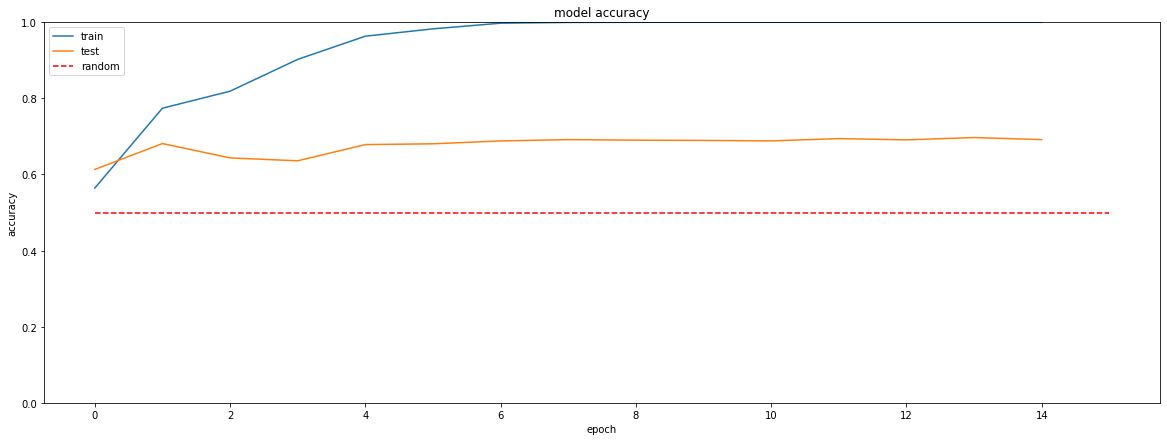

In [34]:
plt.rcParams['figure.figsize'] = (20,7)
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="test")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.hlines(y=0.5, xmin=0, xmax=len(history.history["accuracy"]), color="red", linestyles="dashed", label="random")
plt.ylim([0, 1])
plt.legend()
plt.legend(
  #['train', 'test'],
    loc='upper left')
plt.savefig("../plots/experiment_1.png")
plt.show()

* 99% cases training set performance is better than test set performance, because the model is predicting already seen data. That's the case now
* The model saturates within the first 20 epochs (the same result would be obtained with just those epochs)
* We might be overfitting because the performance is not just very good but perfect on the training set...
* More experiments are needed to validate this model, but it's promising.

#### Evaluate the model

This gives us the accuracy metric of the test set with the model as it is now i.e.
the value of the orange line at the last epoch

Check fraction of cells with class 1 (Wake)

In [35]:
print(f"{round(np.mean(dataset_split['test'][1]), 3) * 100} % cells are awake and the rest are asleep")
# Ideally this is close to 0.5
print("This number is the accuracy of a random classifier, by chance it will get this fraction right")


49.4 % cells are awake and the rest are asleep
This number is the accuracy of a random classifier, by chance it will get this fraction right


In [36]:
loss, acc = data.model.evaluate(*dataset_split["test"][:2], verbose=0)
test_str = 'Test Accuracy: %.1f %%' % (acc * 100)
print(test_str)
with open(test_str_txt, "w") as fh:
    fh.write(test_str + '\n')

Test Accuracy: 69.2 %


#### Save the weights

In [37]:
# data.save(model_name)
# data = Dataset.load(model_name)

#### Make a prediction for a single cell

In [39]:
# pick the first cell of the test set
first_cell = dataset_split["test"][0][0,:].tolist()
yhat = data.predict([first_cell])
print('Predicted score: %.3f' % list(yhat.values())[0])
print(f"Should be {dataset_split['test'][1][0]}")

Predicted score: 0.822
Should be 0


#### Further validation of the result....

In [43]:
class_scores = []
class_preds = []

test_data = dataset_split["test"][0]

for i in tqdm(range(test_data.shape[0])):
    yhat = data.predict([test_data[i,:].tolist()])
    class_preds.append(list(yhat.keys())[0])
    class_scores.append(list(yhat.values())[0])

/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1456 [00:00<?, ?it/s]

In [60]:
ytrue = dataset_split["test"][1]

summ = pd.DataFrame({
    "yhat": class_scores,
    "class": class_preds,
    "ytrue": ytrue,
})

In [61]:
summ["correct_pred"] =  summ.values[:,1] == summ.values[:,2]
summ["incorrect_pred"] = summ.values[:,1] != summ.values[:,2]
summ


,yhat,class,ytrue,correct_pred,incorrect_pred
0,0.999907,0,0,True,False
1,1.000000,0,0,True,False
2,0.999989,5,5,True,False
3,0.851627,2,2,True,False
4,0.825658,5,5,True,False
...,...,...,...,...,...
1451,0.999993,2,2,True,False
1452,1.000000,1,1,True,False
1453,1.000000,6,6,True,False
1454,0.347401,1,0,False,True


In [62]:
#dataset_split["test"][2]

In [63]:
test_obs = pd.merge(dataset_split["test"][2], data.obs, how="left")

In [64]:
summ=pd.concat([summ, test_obs],axis=1)

In [65]:
summ.head()

,yhat,class,ytrue,correct_pred,incorrect_pred,CellID,Age,ClusterID,Clusterings.0,Clusterings.1,...,Sleep_Stage,Treatment,detected,discard,nGene,nUMI,propZero,sizeFactor,sum,total
0,0.999907,0,0,True,False,CAGGGCTCAACAGTGG-fc9729__DGRP_Mix_Sleep_Depriv...,6-9 days,4,3,4,...,ZT 20,Sleep,1622.0,0,1622,4108.0,0.837719,0.674472,4108.0,4108.0
1,1.000000,0,0,True,False,TGAGGTTCACTTCAAG-fc9729__DGRP_Mix_Sleep_Depriv...,6-7 days,4,3,4,...,ZT 8,Wake,4525.0,1,4525,41944.0,0.547274,7.168933,41944.0,41944.0
2,0.999989,5,5,True,False,GACTCTCGTGTTGACT-ce85ae__S2_10x_160920-20200916,5-7 days,4,3,4,...,ZT 8,Wake,1856.0,0,1856,5457.0,0.814307,0.895000,5457.0,5457.0
3,0.851627,2,2,True,False,ATCACTTAGTGAACAT-b0b341__S3_10x_20191023-20191023,7 days,4,3,4,...,ZT 20,Sleep,1752.0,0,1752,5594.0,0.824712,0.814993,5594.0,5594.0
4,0.825658,5,5,True,False,AGTCTCCGTCAAATCC-ce85ae__S2_10x_160920-20200916,5-7 days,4,3,4,...,ZT 8,Sleep,658.0,1,658,1626.0,0.934167,0.189393,1626.0,1626.0


In [66]:
summ.groupby("Condition").sum()

,yhat,class,ytrue,correct_pred,incorrect_pred,Clusterings.0,Clusterings.1,Clusterings.2,Clusterings.3,Clusterings.4,...,Embeddings_Y.2,Percent_mito,detected,discard,nGene,nUMI,propZero,sizeFactor,sum,total
Condition,,,,,,,,,,,,,,,,,,,,,
ZT 14 SD,31.197010,94,96,31,1,96,128,96,128,128,...,29.591022,3.640718,58805.0,2,58805,205914.0,26.116558,29.317875,205914.0,205914.0
ZT 14 sleep,77.802381,231,237,76,3,261,316,237,316,316,...,34.708839,10.276807,145030.0,9,145030,521367.0,64.489746,74.725090,521367.0,521367.0
ZT 2 rebound 12h SD,226.487216,443,428,219,10,735,916,687,916,916,...,17.029377,25.054203,436838.0,30,436838,1795278.0,185.294342,255.774628,1795278.0,1795278.0
ZT 2 sleep drive 14h SD,144.128526,229,226,140,5,459,580,435,580,580,...,8.989573,15.420468,267025.0,18,267025,1004200.0,118.284142,141.358109,1004200.0,1004200.0
ZT 20 midline cross,88.244600,177,178,88,1,283,356,267,356,356,...,22.005627,6.570885,175916.0,12,175916,673128.0,71.399597,96.645912,673128.0,673128.0
ZT 20 sleep,287.025583,548,528,262,36,926,1192,894,1192,1192,...,100.646004,24.244793,548298.0,49,548298,2002588.0,243.142776,301.424683,2002588.0,2002588.0
ZT 20 sleep deprivation,215.223485,401,369,194,30,696,896,672,896,896,...,71.477463,21.231804,411345.0,36,411345,1459433.0,182.844925,219.431213,1459433.0,1459433.0
ZT 8 20h SD,63.190920,342,362,55,14,207,276,207,276,276,...,40.386845,6.251998,114716.0,20,114716,395232.0,57.522663,62.329391,395232.0,395232.0
ZT 8 gab,76.115061,420,438,71,10,251,324,243,324,324,...,72.935493,7.518210,129407.0,21,129407,400524.0,68.052826,63.522930,400524.0,400524.0


In [67]:
summ.groupby("Genotype").sum()

,yhat,class,ytrue,correct_pred,incorrect_pred,Clusterings.0,Clusterings.1,Clusterings.2,Clusterings.3,Clusterings.4,...,Embeddings_Y.2,Percent_mito,detected,discard,nGene,nUMI,propZero,sizeFactor,sum,total
Genotype,,,,,,,,,,,,,,,,,,,,,
line_287,155.409705,579,573,144,16,488,640,480,640,640,...,107.590340,13.756172,260098.0,15,260098,798320.0,133.977188,119.779808,798320.0,798320.0
line_303,162.372277,396,397,146,20,522,664,498,664,664,...,44.577148,15.555780,320399.0,27,320399,1309891.0,133.944077,192.866348,1309891.0,1309891.0
line_313,68.884057,68,67,69,1,234,280,210,280,280,...,24.431211,3.838529,151599.0,15,151599,621403.0,54.832516,98.771049,621403.0,621403.0
line_359,15.751792,4,0,15,1,48,64,48,64,64,...,17.128075,0.794291,31909.0,4,31909,124335.0,12.807504,20.968523,124335.0,124335.0
line_379,259.685716,655,656,244,26,850,1080,810,1080,1080,...,87.123665,26.131338,503289.0,50,503289,1864700.0,219.645920,280.476501,1864700.0,1864700.0
line_441,242.670214,524,515,229,19,776,992,744,992,992,...,110.844986,20.976332,446411.0,39,446411,1567675.0,203.336563,234.721939,1567675.0,1567675.0
line_646,109.026463,353,351,106,7,387,452,339,452,452,...,38.902752,11.826299,203800.0,20,203800,771933.0,92.609802,115.383301,771933.0,771933.0
line_88,247.688806,320,306,239,14,767,1012,759,1012,1012,...,104.420280,22.582960,468627.0,29,468627,1627937.0,206.113861,245.407028,1627937.0,1627937.0
line_892,63.732961,100,101,63,1,200,256,192,256,256,...,-9.215744,6.604895,125218.0,9,125218,527045.0,51.471935,72.548286,527045.0,527045.0


In [68]:
summ.groupby("Run").sum()

,yhat,class,ytrue,correct_pred,incorrect_pred,Clusterings.0,Clusterings.1,Clusterings.2,Clusterings.3,Clusterings.4,...,Embeddings_Y.2,Percent_mito,detected,discard,nGene,nUMI,propZero,sizeFactor,sum,total
Run,,,,,,,,,,,,,,,,,,,,,
20180419,234.614130,31,0,232,8,760,960,720,960,960,...,174.983536,10.607087,461040.0,51,461040,1645433.0,193.872940,273.382324,1645433.0,1645433.0
20191009,337.009635,370,342,329,13,1066,1368,1026,1368,1368,...,-48.366936,45.411392,624681.0,37,624681,2294930.0,279.500641,323.791565,2294930.0,2294930.0
20191023,347.025318,696,698,340,9,1119,1396,1047,1396,1396,...,74.231094,27.350485,693884.0,50,693884,2869214.0,279.576874,411.135834,2869214.0,2869214.0
20191106,155.878722,466,474,154,4,498,632,474,632,632,...,82.272377,19.257898,284178.0,14,284178,998975.0,129.567978,142.707123,998975.0,998975.0
20200902,123.954674,578,548,81,56,419,548,411,548,548,...,106.674614,9.142261,239939.0,31,239939,825073.0,112.994095,130.569183,825073.0,825073.0
20200916,158.344620,817,845,147,22,515,676,507,676,676,...,138.321213,14.019900,281692.0,23,281692,897814.0,140.816711,140.956940,897814.0,897814.0
20200924,58.847145,354,366,55,6,183,244,183,244,244,...,49.339127,5.373086,97674.0,22,97674,318336.0,51.227715,51.743824,318336.0,318336.0


In [53]:
summ.to_csv(summary_csv)

In [159]:
# summ["Condition"].value_counts()

ZT 20 sleep                271
ZT 20 sleep deprivation    230
ZT 2 rebound 12h SD        208
ZT 2 sleep drive 14h SD    167
ZT 8 wake                  155
ZT 14 sleep                 90
ZT 20 midline cross         87
ZT 8 gab                    82
ZT 8 20h SD                 81
ZT 14 SD                    45
ZT 8 wake stimulation       40
Name: Condition, dtype: int64